In [3]:
using POMDPs # for MDP type
using DiscreteValueIteration
using POMDPPolicies
using POMDPModelTools #for sparse cat 
using Parameters
using Random
using Plots; default(fontfamily="Computer Modern", framestyle=:box) # LaTex-style
using QuickPOMDPs
using Distributions 
#using PlotlyJS
using LinearAlgebra

In [4]:
Random.seed!(0xC0FFEE)

MersenneTwister(12648430)

**States**

In [5]:
# A state s in the evacuation problem is a discrete set of 4 values: 
# chairs remaining, time remaining, family size, and visa status
struct State
    c::Int # chairs remaining 
    t::Int # time remaining 
    f::Int # family size 
    v::Int # visa status 
end 

**Environment Parameters**

In [6]:
# assume families normally distributed as integers around average family size in afghanistan of 8. 
# Truncated to include 1 or greater and rounded to be integers 
@with_kw struct EvacuationParameters
    # need the probability that a particular family shows up at the door....
    #family_sizes::Vector{Int} =  [trunc(Int, x) for x in rand(TruncatedNormal(3, 1, 1, Inf), 10)] 
    family_sizes::Vector{Int} = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    visa_status::Vector{Int} = [-4, -3, -2, -1, 0, 1, 2, 3, 4] #TODO: map to various status 
    capacity::Int = 20
    time::Int = 60
    size::Tuple{Int, Int} = (length(visa_status), length(family_sizes)) # size of grid 
    p_transition::Real = 0.8 # don't we always transition into this since time moves forward? I'm confused... 
    null_state::State = State(-1, -1, -1 ,-1) # is there someway to do this???
end


EvacuationParameters

In [7]:
params = EvacuationParameters(); 

In [8]:
params.family_sizes

10-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10

In [9]:
# The state space S for the evacuation problem is the set of 
# all combinations 
# Question: Do I need the end state here? 
#𝒮 = [[State(c, t, f, v) for  c=1:params.capacity, t=1:params.time, f=1:params.size[2], v=1:params.size[1]]]
𝒮 = []

for c in 0:params.capacity # capacity ends at 0 
    for t in 0:params.time # time ends at 0 
        for f in params.family_sizes # family size here we should have the ACTUAL family sizes 
            for v in params.visa_status # actual visa statuses 
                new = State(c, t, f, v) 
                𝒮 = [𝒮; new]
            end
        end        
    end
end
𝒮 = [𝒮; params.null_state]




115291-element Vector{Any}:
 State(0, 0, 1, -4)
 State(0, 0, 1, -3)
 State(0, 0, 1, -2)
 State(0, 0, 1, -1)
 State(0, 0, 1, 0)
 State(0, 0, 1, 1)
 State(0, 0, 1, 2)
 State(0, 0, 1, 3)
 State(0, 0, 1, 4)
 State(0, 0, 2, -4)
 State(0, 0, 2, -3)
 State(0, 0, 2, -2)
 State(0, 0, 2, -1)
 ⋮
 State(20, 60, 9, 3)
 State(20, 60, 9, 4)
 State(20, 60, 10, -4)
 State(20, 60, 10, -3)
 State(20, 60, 10, -2)
 State(20, 60, 10, -1)
 State(20, 60, 10, 0)
 State(20, 60, 10, 1)
 State(20, 60, 10, 2)
 State(20, 60, 10, 3)
 State(20, 60, 10, 4)
 State(-1, -1, -1, -1)

In [10]:
#@show 𝒮

In [11]:
#@show size(𝒮)
#@show size[1,1,1,1]
#(20, 60, 10, 10)
#length(𝒮[1]) = 120000 = 100*60*10*10

**Actions**

In [12]:
# the possible actions are whether accept or reject a family at the gate 
@enum Action REJECT ACCEPT

In [13]:
𝒜 = [REJECT, ACCEPT]

2-element Vector{Action}:
 REJECT::Action = 0
 ACCEPT::Action = 1

In [14]:
# create policy grid showing the best action in each state at a particular time and capacity 
#State(c, t, f, v)
function policy_grid(policy::Policy, xmax::Int, ymax::Int, time::Int, capacity::Int)
    viz_action = Dict(REJECT => "",
                  ACCEPT => "+",)
    grid = Array{String}(undef, xmax, ymax)
    for x = 1:xmax, y = 1:xmax
        s = State(capacity, time, x, y) # x is family size, v is visa status 
        grid[x,y] = viz_action[action(policy, s)] # need to define this action space 
    end
    return grid
end


policy_grid (generic function with 1 method)

In [15]:
# only inbounds if room for the family [assuming would not separate even though might]
# and if time is available to enter the airport 
validtime(s::State) = 0 < s.t 

validtime (generic function with 1 method)

In [16]:
validcapacity(s::State) = 0 ≤ s.c # maybe try back to 0 

validcapacity (generic function with 1 method)

**Transition Function** 

In [17]:
function T(s::State, a::Action)
    # randomly sample a family size and visa status 
    # don't think we need this with the rest of the code in our transition function...
    next_states = []
    if validtime(s) 
        # how do we account for the null state/termination in the transition function? 
        f′ = rand(params.family_sizes)
        v′ = rand(params.visa_status) # TODO: possibly make this weighted in some way 
        #next_states = Vector{State}(undef, Nₐ) 
        if a == ACCEPT 
            next_state_accept = State(s.c - s.f, s.t - 1, f′, v′) # they get seats
            next_state_reject = State(s.c, s.t - 1, f′, v′)
            push!(next_states, next_state_accept)
            push!(next_states, next_state_reject)
            if !validcapacity(next_state_accept) 
                probabilities = [0, 1] #no room for full family :( so we make probability 0 to accept and 1 reject
            else
                probabilities = [.80, .20]
            end

        elseif a == REJECT
#             Nₐ = 1
#             next_states = Vector{State}(undef, Nₐ) 
            probabilities = [1.0]
            push!(next_states, State(s.c, s.t - 1, f′, v′))
            #next_states[1] =  #where they don't get seats
            # handle out-of-bounds transitions
        end
    else
        push!(next_states,params.null_state)
        probabilities = [1]
    end
    return SparseCat(next_states, probabilities)
end

    

T (generic function with 1 method)

In [18]:
#next_states = Vector{State}(undef, 1) 

In [19]:
# struct State
#     c::Int # chairs remaining 
#     t::Int # time remaining 
# #     f::Int # family size 
# #     v::Int # visa status 
# # end 
T(State(-1, -1, 4, 5), ACCEPT)

# this is the problem 

# ACCEPT: State(50, 9, ANYTHING, ANYTHING)
# ACCEPT: State(42, 9, ANYTHING, ANYTHING)
# REJECT: State(50, 9, ANYTHING, ANYTHING)

                                   SparseCat distribution           
                         ┌                                        ┐ 
   State(-1, -1, -1, -1) ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1.0   
                         └                                        ┘ 

In [20]:
T(State(4, 3, 4, 5), ACCEPT)


                               SparseCat distribution           
                     ┌                                        ┐ 
   State(0, 2, 9, 0) ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 0.8   
   State(4, 2, 9, 0) ┤■■■■■■■■■ 0.2                             
                     └                                        ┘ 

In [21]:
T(State(-1, -1, 4, 5), ACCEPT)

                                   SparseCat distribution           
                         ┌                                        ┐ 
   State(-1, -1, -1, -1) ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 1.0   
                         └                                        ┘ 

**Reward Function**

In [22]:
function R(s::State, a::Action)
    # reward is just the visa status times family size i think! 
    if a == ACCEPT
        return s.v*s.f
    end
    return 0
end 

R (generic function with 1 method)

In [23]:
#render(mdp; show_rewards=true)
#@bind γ Slider(0:0.05:1, default=0.95, show_value=true)
# hard code for now. maybe come back to it. 
γ = 0.95

0.95

In [24]:
# when time is 0...possibly encode this into the parameters 
#termination(s::State) = (s.t == 0 || s.c == 0)
# can probably do this instead of overriding ... alternate possibility: 
# # not sure we need this... to say when time and capacity are equal

#termination(s::State) = (s.t == params.null_state.t && s.c == params.null_state.c)
#Base.:(==)(s1::State, s2::State) = (s1.t == s2.t) && (s1.c == s2.c)
termination(s::State)= s == params.null_state # change to 1 or the other 

termination (generic function with 1 method)

In [25]:
#termination(State(0,1,-5,0))

**MDP Formulation**

In [26]:
# We define the Airport abstract MDP type so we can reference it in other methods.
abstract type Evacuation <: MDP{State, Action} end

In [27]:
  # struct State
        #     c::Int # chairs remaining 
        #     t::Int # time remaining 
        #     f::Int # family size 
        #     v::Int # visa status 
        # end 
c_initial = params.capacity
t_initial = params.time
f_initial = rand(params.family_sizes, 1)[1]
v_initial = rand(params.visa_status, 1)[1]

initial_state = State(c_initial, t_initial, f_initial, v_initial)

State(20, 60, 2, 1)

In [28]:
statetype = typeof(initial_state)
initialstate_array = [initial_state]

1-element Vector{State}:
 State(20, 60, 2, 1)

In [29]:
#render = plot_evac

In [30]:
mdp = QuickMDP(Evacuation,
    states       = 𝒮,
    actions      = 𝒜,
    transition   = T,
    reward       = R,
    discount     = γ,
    initialstate = initialstate_array, # change this from sampling whole state since we always start max time and cap.
    isterminal   = termination,
    render       = render,
    statetype    = statetype #
    );

In [31]:
#render(mdp)

In [32]:
solver = ValueIterationSolver(max_iterations=30, belres=1e-6, verbose=true);

**Policy**

In [33]:
# Set discount factor to variable gamma and solve the MDP to obptain policy pi mapping states to actions a

In [34]:
policy = solve(solver, mdp) 

[Iteration 1   ] residual:        304 | iteration runtime:    586.356 ms, (     0.586 s total)
[Iteration 2   ] residual:        121 | iteration runtime:    580.702 ms, (      1.17 s total)
[Iteration 3   ] residual:       93.4 | iteration runtime:    477.591 ms, (      1.64 s total)
[Iteration 4   ] residual:        113 | iteration runtime:    479.231 ms, (      2.12 s total)
[Iteration 5   ] residual:        111 | iteration runtime:    486.379 ms, (      2.61 s total)
[Iteration 6   ] residual:        113 | iteration runtime:    485.141 ms, (       3.1 s total)
[Iteration 7   ] residual:       99.7 | iteration runtime:    449.531 ms, (      3.54 s total)
[Iteration 8   ] residual:        108 | iteration runtime:    476.204 ms, (      4.02 s total)
[Iteration 9   ] residual:       99.9 | iteration runtime:    470.662 ms, (      4.49 s total)
[Iteration 10  ] residual:        115 | iteration runtime:    521.997 ms, (      5.01 s total)
[Iteration 11  ] residual:        104 | iteration 

Excessive output truncated after 10488640 bytes.

policy = solve(solver, mdp) = 

ValueIterationPolicy:
 State(0, 0, 1, -4) -> REJECT
 State(0, 0, 1, -3) -> REJECT
 State(0, 0, 1, -2) -> REJECT
 State(0, 0, 1, -1) -> REJECT
 State(0, 0, 1, 0) -> REJECT
 State(0, 0, 1, 1) -> ACCEPT
 State(0, 0, 1, 2) -> ACCEPT
 State(0, 0, 1, 3) -> ACCEPT
 State(0, 0, 1, 4) -> ACCEPT
 State(0, 0, 2, -4) -> REJECT
 State(0, 0, 2, -3) -> REJECT
 State(0, 0, 2, -2) -> REJECT
 State(0, 0, 2, -1) -> REJECT
 State(0, 0, 2, 0) -> REJECT
 State(0, 0, 2, 1) -> ACCEPT
 State(0, 0, 2, 2) -> ACCEPT
 State(0, 0, 2, 3) -> ACCEPT
 State(0, 0, 2, 4) -> ACCEPT
 State(0, 0, 3, -4) -> REJECT
 State(0, 0, 3, -3) -> REJECT
 State(0, 0, 3, -2) -> REJECT
 State(0, 0, 3, -1) -> REJECT
 State(0, 0, 3, 0) -> REJECT
 State(0, 0, 3, 1) -> ACCEPT
 State(0, 0, 3, 2) -> ACCEPT
 …

In [35]:
action(policy, State(20, 60, 4, 3))
# we now have a policy! 

ACCEPT::Action = 1

In [36]:
# a = action(policy, s) # returns the optimal action for state s
# value(policy, s) # returns the optimal value at state s
#actions = [action(policy, valid_state) for valid_state in valid_states]

**Additional possible needs**

In [37]:
# helper functions to:
# 1. get all the values from a policy


begin
    function one_based_policy!(policy)
        # change the default action in the policy (all zeros) to all ones (if needed) e.g. just accept everyone
        if all(iszero, policy.policy)
            policy.policy[:] = ones(eltype(policy.policy), length(policy.policy))
        end
    end
    
    # no idea if this is right 
    function get_rewards(mdp::QuickMDP{Evacuation}, policy::Policy)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        valid_actions = [action(policy, valid_state) for valid_state in valid_states]
        # can I map a state and action to reward? 
        state_actions = zip(valid_states, valid_actions) 
        U = map(state_action->reward(mdp, state_action), state_actions)
    end
    
    function values(mdp::QuickMDP{Evacuation}, policy::Policy)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        U = map(s->value(policy, s), valid_states)
    end
    
#     # WHAT DOES THIS ONE DO? Monte carlo tree search... don't need 
#     function values(mdp::QuickMDP{Evacuation}, planner::MCTSPlanner)
#         null_state = params.null_state
#         valid_states = setdiff(states(mdp), [null_state])
#         U = []
#         for s in valid_states
#             u = 0
#             try
#                 u = value(planner, s)
#             catch
#                 # state not in tree
#             end
#             push!(U, u)
#         end
#         return U
#     end
    
    function values(mdp::QuickMDP{Evacuation}, policy::ValuePolicy)
        maxU = mapslices(maximum, policy.value_table, dims=2)
        return maxU[1:end-1] # remove null_state
    end
    
    struct NothingPolicy <: Policy end
    
    # Use this to get a stationary grid of rewards
    function values(mdp::QuickMDP{Evacuation}, policy::Union{NothingPolicy, FunctionPolicy})
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        rewards = map(s->reward(mdp, s), valid_states)
    end
end

values (generic function with 3 methods)

**Visualizations**

In [38]:
# struct evacPolicy <: Policy end 

In [39]:
# function plot_evac(mdp::MDP,
#         policy::Policy=NothingPolicy(),  # our policy will have states State(c, t, f, v) with actions (reject/accept)
#         iter=0,
#         discount=NaN; 
#         outline=true,
#         show_policy=true,
#         show_rewards=false, 
#         outline_state::Union{State, Nothing}=nothing
#     )
                   
#     gr()
    
#     # what do here? 
# #     if policy isa NothingPolicy
# #         # override when the policy is empty
# #         show_policy = false
# #     end
    
#     show_policy = false
    
# #     U = zeros(1, params.size[1]*params.size[2]) # tryung 
# #     policy = ones(1, params.size[1]*params.size[2]) # how do you make a policy? 
# #    DISCUSS 
#     if iter == 0
#         # solver has not been run yet, so we just plot the raw rewards
#         # overwrite policy at time=0 to be emp
#         U = get_rewards(mdp, policy)
#     else
#         # otherwise, use the Value Function to get the values (i.e., utility)
#         U = values(mdp, policy)
#     end
    
#     # reshape to grid
#     (xmax, ymax) = params.size # reshape grid to family size * visa status
#     Uxy = reshape(U, xmax, ymax)
#     # plot values (i.e the U matrix)
#     fig = heatmap(Uxy',
#                   legend=:none,
#                   aspect_ratio=:equal,
#                   framestyle=:box,
#                   tickdirection=:out)
#     xlims!(0.5, xmax+0.5)
#     ylims!(0.5, ymax+0.5)
#     xticks!(1:xmax)
#     yticks!(1:ymax)
#     rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
#     # not sure the visualization makes perfect sense since x and y will not have every possible family size...
#     # policy_grid(policy::Policy, xmax::Int, ymax::Int, time::Int, capacity::Int)
#     # Let x represent family size, y represent visa status 
#     for x in 1:xmax, y in 1:ymax 
#         policy_grid(policy, xmax, ymax, 0, 0) # time = 0 and capacity = 0 here - the last time step 
#         annotate!([(x, y, (grid[x,y], :center, 12, "Computer Modern"))])
#         rect = rectangle(1, 1, x - 0.5, y - 0.5)
#         plot!(rect, fillalpha=0, linecolor=:gray)
        
#         # Some if statement here to say: 
#         # if policy at State(c,t,f,v) == ACCEPT
#             # color = green
#         # else 
#             # no color 
#     end
#         title!("Evacuation Policy Plot$extra_title")
#         return fig 
# end

In [40]:
# plot_evac(mdp)

In [41]:
# policy
# act = action(policy, State(0,0,1,5))


**Visualizations Trial 2**

In [75]:
function vis(policy, c, t) #pass in policy and chairs and time remaing. Spit out graph of family size versus visa status.
    (vi, fa) = params.size  #visa, family 8, 15
    policyGraph = zeros(vi, fa) #8 by 15 matrix of zeroes
    
    for f in 1:fa
        for v in 1:vi
            act = action(policy, State(c, t, f, v - 5))
            if act == ACCEPT
                policyGraph[v,f] = 100
            else
                policyGraph[v,f] = 0
            end
        end
    end
    
    x=params.visa_status
    y=params.family_sizes
    z=policyGraph'
    return heatmap(x, y, z, aspect_ratio = 1, legend = :none, xlims = (-4,4), xlabel = "Visa Status", ylabel = "Family Size", ylims = (1,10), title= "Policy"
)
    
end

vis (generic function with 1 method)

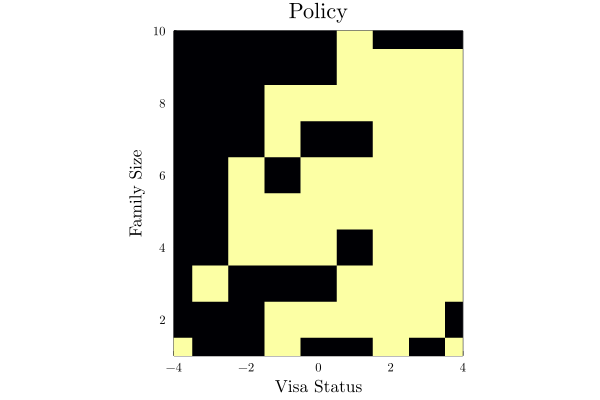

In [76]:
p = vis(policy, 20, 20)
# plot(p)
#policyGraph = zeros(5,3) #turns into 5 by 3 matrix
#(xmax, ymax) = params.size    
